# Группа: DST-48
**Sergey Pinaev - binom1982@gmail.com**
# Проект №8: Возьмете Бэтмобиль? 
Прогнозирование стоимости автомобиля по характеристикам, текстовому описанию и изображениям

Ссылка на соревнование: [[SF-DST] Car Price prediction](https://www.kaggle.com/c/sf-dst-car-price-prediction-part2)

<p align="center" width="100%">
<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg" width="600"/>
</p>
<hr>

## Этапы работы над проектом:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [1]:
# !pip install -q tensorflow==2.3

In [2]:
#аугментации изображений
# !pip install albumentations -q

# Data


Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

# Libraries

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
import seaborn as sns
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline
plt.style.use('fivethirtyeight')
# Подключаем форматирование Markdown
from IPython.display import Markdown

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

# Чтобы вычисления проходили на GPU необходимо чтобы tensorflow определил GPU.
# Как это сделать практически без боли написано здесь https://artificialintelligence.so/forums/discussion/how-to-install-tensorflow/
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices()
# Подключим видеокарту
!nvidia-smi -L
# !pip freeze > requirements.txt

# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

Python       : 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.19.5
Tensorflow   : 2.5.0
Keras        : 2.5.0
Num GPUs Available:  1
GPU 0: NVIDIA GeForce RTX 2070 SUPER (UUID: GPU-f6280479-d16b-33b8-dd70-6511eca96aa8)


# Functions

In [4]:
def myround(x, prec=2, base=.05):
    return round(base * round(float(x)/base),prec)


def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))


def get_emission_limits(data_series):
    '''
    Возвращает кортеж границ выбросов вычесленных на основе межвартильного размаха и 1 и 99 перцентиль.
    При необходимости данные выходящие за нижнюю и верхнюю границу можно не удалять а присваивать им значение  1 и 99 перцентиля.
    df.loc[df['column'] < min_emission_limits, 'column'] = perc01
    df.loc[df['column'] > max_emission_limits, 'column'] = perc99
    '''
    perc25, perc75 = np.percentile(data_series,[25,75])
    perc1, perc99 = np.percentile(data_series,[1,99])
    IQR = perc75 - perc25
    min_emission_limits = perc25 - 1.5*IQR
    max_emission_limits = perc75 + 1.5*IQR

    '''Выводит распределение данных для каждого столбца в датасете'''
    l = ['| P1 | Min bound emission | P25 | IQR | P75 | Max bound emission | P99 |',
         '|-----|:-----:|----|-----|----|:-----:|-----|',
        f'|{perc1}|{min_emission_limits}|{perc25}|{IQR}|{perc75}|{max_emission_limits}|{perc99}|']
            
    display(Markdown('\n'.join(l)))
    return perc1, min_emission_limits, max_emission_limits, perc99        
  


# Load data

In [5]:
# Работаю с локального компьютера
DATA_DIR = 'G:/Datasets/module_8/data/' 
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [6]:
isWorking = False # флаг для запуска кода
if (isWorking):
    # split данных
    data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)
    # Наивная модель
    predicts = []
    for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
        query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
        predicts.append(data_train.query(query)['price'].median())
    # заполним не найденные совпадения
    predicts = pd.DataFrame(predicts)
    predicts = predicts.fillna(predicts.median())

    # округлим
    predicts = (predicts // 1000) * 1000

    #оцениваем точность
    print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

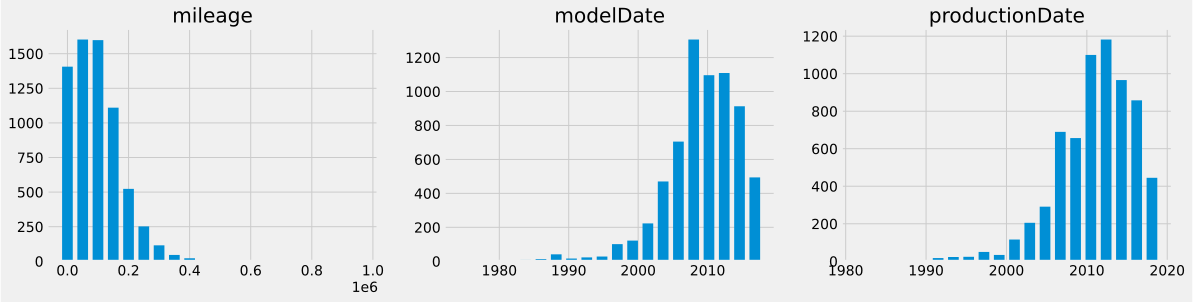

In [7]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

In [8]:
# используем модуль для быстрого первичного анализа данных
# import pandas_profiling
# pandas_profiling.ProfileReport(train)

In [9]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


Пропуски: 0


седан                   3541
внедорожник 5 дв.       2896
купе                     543
хэтчбек 5 дв.            364
лифтбек                  299
универсал 5 дв.          196
минивэн                  178
купе-хардтоп             111
родстер                   88
хэтчбек 3 дв.             57
кабриолет                 54
компактвэн                 8
внедорожник 3 дв.          5
лимузин                    5
внедорожник открытый       4
пикап двойная кабина       3
седан 2 дв.                1
Name: bodyType, dtype: int64

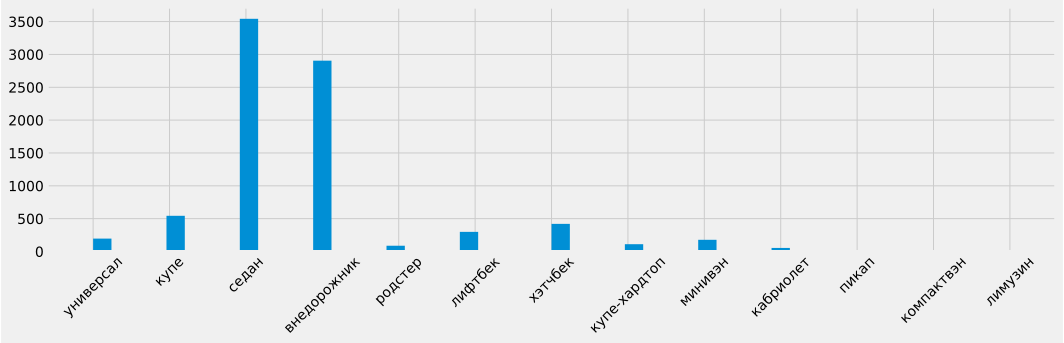

In [10]:
# 1) bodyType - тип автомобиля
print('Пропуски:', data.bodyType.isna().sum())
# слишком много ненужной информации о дверях например
display(data.bodyType.value_counts(dropna=False))
# оставим только первое слово
data.bodyType = data.bodyType.apply(lambda p: p.split()[0]).astype("category")
#display(data.bodyType.value_counts(dropna=False))

data.bodyType.hist(figsize=(15,5), log=False, bins=50, xrot=45);
plt.tight_layout()

In [11]:
# 7) engineDisplacement - объем двигателя
print('Пропуски:', data.engineDisplacement.isna().sum())
# но если преобразовать в число то нужно убрать слово LTR 
# display(data.engineDisplacement.value_counts(dropna=False))

data.engineDisplacement = data.engineDisplacement.apply(lambda p: p.rpartition(' LTR')[0])
# display(data.engineDisplacement.value_counts(dropna=False))
data.engineDisplacement = data.engineDisplacement.apply(lambda p: p if p != '' and p != 'undefined' else None).astype("float")

# display(data.engineDisplacement.value_counts(dropna=False))


Пропуски: 0


2.0    3125
3.0    2615
1.5     636
4.5     475
2.5     339
5.5     304
3.5     291
4.0     282
5.0     146
6.0      93
1.0      33
6.5       8
0.5       6
Name: engineDisplacement, dtype: int64

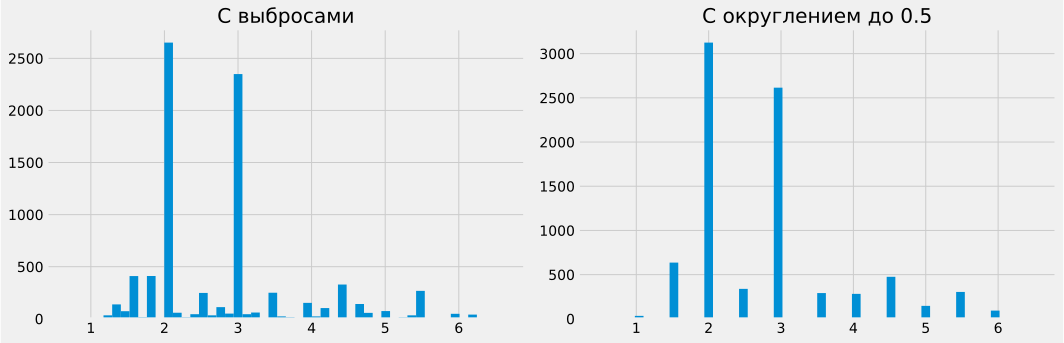

In [12]:
# заполним пропуски средним
data.engineDisplacement.fillna(round(data.engineDisplacement.mean(),1), inplace=True)
# display(data.engineDisplacement.value_counts(dropna=False))


fig ,ax = plt.subplots(1,2,figsize=(10, 20));
ax1,ax2 = ax.flatten()
ax1.set_title('С выбросами')
data.engineDisplacement.hist(figsize=(15,5), log=False, bins=50, ax=ax1);

# округлим разброс объема двигателя до 0.5
data.engineDisplacement = data.engineDisplacement.apply(lambda p: myround(p, 1, .5))
display(data.engineDisplacement.value_counts(dropna=False))
# # Удалять выбросы не будем, тк можно удалить данные из тестового датасета, поэтому заменим выбросы крайними значениями. 
# perc1, min_emission_limits, max_emission_limits, perc99 = get_emission_limits(data.enginePower)

# data.enginePower.loc[data.enginePower < min_emission_limits] = int(perc1)
# data.enginePower.loc[data.enginePower > max_emission_limits] = int(perc99)

ax2.set_title('С округлением до 0.5')
data.engineDisplacement.hist(figsize=(15,5), log=False, bins=50, ax=ax2);
# display(data.mileage.value_counts(dropna=False))
plt.tight_layout()

Пропуски: 0


184 N12    759
249 N12    655
190 N12    420
245 N12    355
306 N12    344
          ... 
520 N12      1
132 N12      1
430 N12      1
591 N12      1
174 N12      1
Name: enginePower, Length: 154, dtype: int64

| P1 | Min bound emission | P25 | IQR | P75 | Max bound emission | P99 |
|-----|:-----:|----|-----|----|:-----:|-----|
|120.0|-15.0|180.0|130.0|310.0|505.0|580.0|

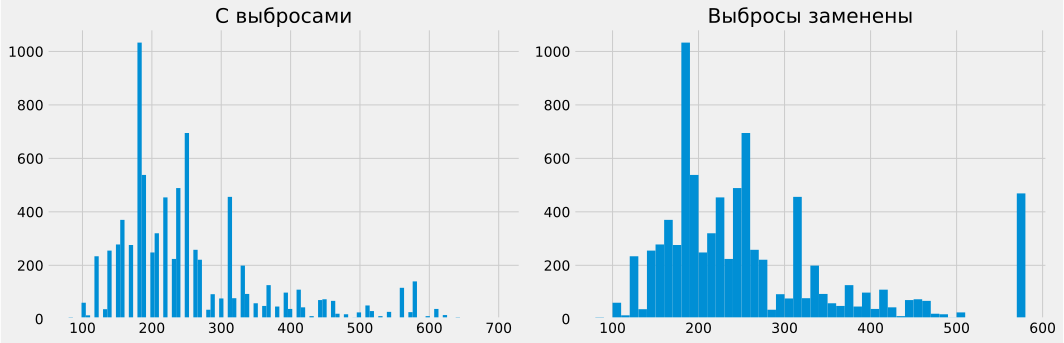

In [13]:
# 8) enginePower - мощность двигателя
print('Пропуски:', data.enginePower.isna().sum())
display(data.enginePower.value_counts(dropna=False))
# если преобразовать в число то есть слово LTR

data.enginePower = data.enginePower.apply(lambda p: p.rpartition(' N12')[0])
data.enginePower = data.enginePower.apply(lambda p: p if p != '' else None).astype("float")

# округлим мощность до 10 лошадиных сил
data.enginePower = data.enginePower.apply(lambda p: round(p, -1)).astype("int")

# display(data.enginePower.isna().sum()) # пропусков нет
# display(data.enginePower.value_counts(dropna=False))

# по графику видно что есть выбросы
# data.enginePower.hist(figsize=(15,5), log=False, color='orange', bins=100);
fig ,ax = plt.subplots(1,2,figsize=(10, 20))
ax1,ax2 = ax.flatten()
ax1.set_title('С выбросами')
data.enginePower.hist(figsize=(15,5), log=False, bins=100, ax=ax1);

# Удалять выбросы не будем, тк можно удалить данные из тестового датасета, поэтому заменим выбросы крайними значениями. 
perc1, min_emission_limits, max_emission_limits, perc99 = get_emission_limits(data.enginePower)

data.loc[data.enginePower < min_emission_limits, 'enginePower'] = int(perc1)
data.loc[data.enginePower > max_emission_limits, 'enginePower'] = int(perc99)
# data.enginePower.loc[data.enginePower < min_emission_limits] = int(perc1)
# data.enginePower.loc[data.enginePower > max_emission_limits] = int(perc99)

ax2.set_title('Выбросы заменены')
data.enginePower.hist(figsize=(15,5), log=False, bins=50, ax=ax2);
# display(data.mileage.value_counts(dropna=False))
plt.tight_layout()

In [14]:
#создадим новые признаки на основе существующих: возраст модели
data['model_age'] = (2021 - data.modelDate)
data['model_age'].value_counts(dropna=False)

10    830
8     739
7     667
6     656
12    655
13    562
9     548
14    542
5     467
11    407
15    345
16    321
4     298
17    242
3     234
18    146
19    135
2      82
21     80
20     76
22     58
23     56
31     48
27     31
26     25
24     16
25     15
29     14
34     11
37     10
36      7
32      5
39      5
42      4
30      4
46      2
33      2
40      2
44      2
50      1
28      1
35      1
45      1
Name: model_age, dtype: int64

In [15]:
#cгенерируем признак - пробег за год
data['mile_per_year'] = (data['mileage'] / data['model_age']).astype("int")
data['mile_per_year'].value_counts(dropna=False)

15000    68
10000    61
12500    51
13000    44
7000     41
         ..
4624      1
10107     1
9704      1
31200     1
788       1
Name: mile_per_year, Length: 4291, dtype: int64

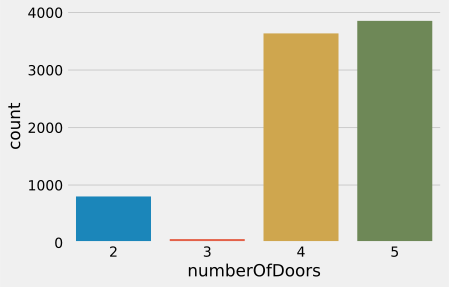

In [16]:
#palette='gist_rainbow'
#palette='viridis'
sns.countplot(x = 'numberOfDoors', data = data);

Пропуски: 1


{'3 или более': 3311, '1\xa0владелец': 2526, '2\xa0владельца': 2515, nan: 1}

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price,model_age,mile_per_year
6665,седан,AUDI,чёрный,машина в идеале! вложено примерно 400тыс.руб \...,4.0,360,бензин,160000,1999,S8,...,автоматическая,NaN,10 лет и 7 месяцев,Оригинал,полный,Левый,1,600000.0,22,7272


{'3 или более': 3311, '1 владелец': 2526, '2 владельца': 2515}

<AxesSubplot:xlabel='Владельцы', ylabel='count'>

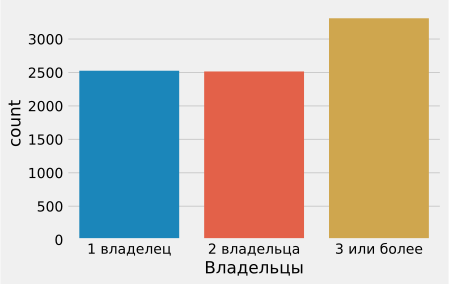

In [17]:
# 26) Владельцы - количество владельцев
print('Пропуски:', data.Владельцы.isna().sum())
display(data.Владельцы.value_counts(dropna=False).to_dict())

display(data[data.Владельцы.isna()])
# Тк пропуски встречаются только в трайне - удалим их
data = data[~data.Владельцы.isna()]

data.Владельцы = data.Владельцы.apply(lambda p: p.replace(u'\xa0', u' ') )
display(data.Владельцы.value_counts(dropna=False).to_dict())

# owners_dic = {'1 владелец': 1, '2 владельца': 2, '3 или более': 3 }
# data.Владельцыа = data.Владельцы.map(owners_dic)
# display(data.Владельцыа.value_counts(dropna=False))

# Преобразуем признак в категориальный с определенным порядком категорий
data.Владельцы = pd.Categorical(data.Владельцы, categories=['1 владелец', '2 владельца', '3 или более'], ordered=False)
sns.countplot(x = 'Владельцы', data = data)

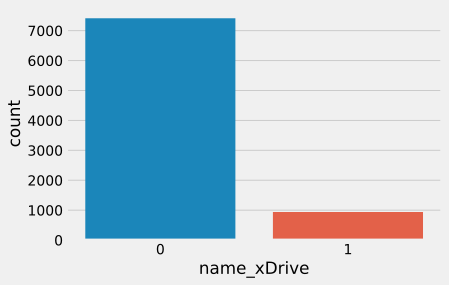

In [18]:
#Признак 'name' содержит данные, которые уже есть в других столбцах.Сократим размерность, 
# выделив наличие xDrive в качестве отдельного признака, а признак name удалим
#сгенерируем новый признак:
data['name_xDrive'] = data['name'].apply(lambda x: 1 if 'xDrive' in x else 0)
sns.countplot(x = 'name_xDrive', data = data);

C:\Users\binom\anaconda3\envs\tensorflow_25\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\binom\anaconda3\envs\tensorflow_25\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


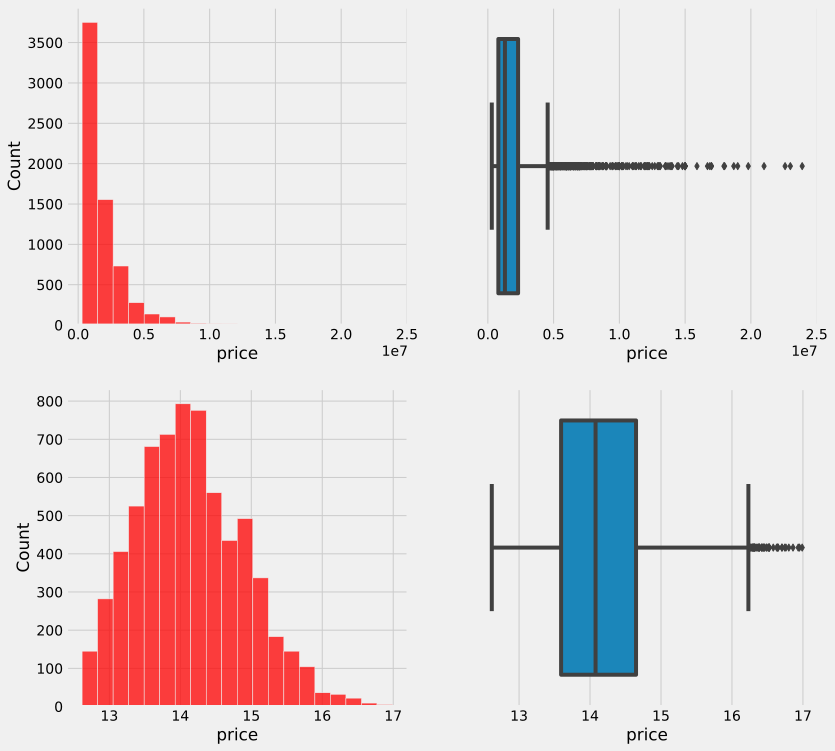

In [19]:
#Выбросы не будем удалять, в дальнейшем прологарифмируем их
fig,ax = plt.subplots(2,2,figsize=(12,12))
ax1,ax2,ax3,ax4 = ax.flatten()
sns.histplot(data[data['sample'] == 1]['price'], bins=20, color='r', ax=ax1);
sns.boxplot(data[data['sample'] == 1]['price'], ax=ax2);
sns.histplot(np.log(data[data['sample'] == 1]['price']), bins=20, color='r', ax=ax3);
sns.boxplot(np.log(data[data['sample'] == 1]['price']), ax=ax4);
# sns.pointplot(y='Age',x='Survived',data=train,ax=ax3)
# sns.violinplot(y='Age',x='Survived',data=train,ax=ax4)

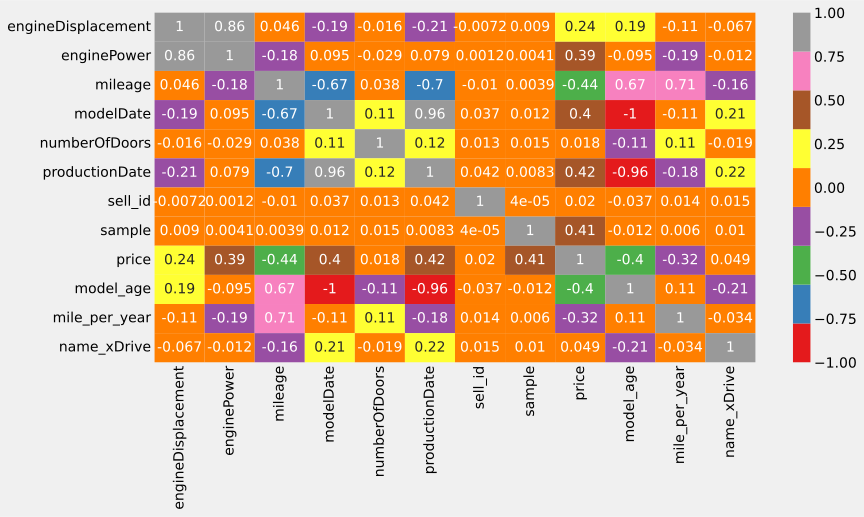

In [20]:
# Посмотрим на корреляцию признаков
cor = data.corr()
plt.figure(figsize=(12,6))
sns.heatmap(cor,cmap='Set1',annot=True);

# Большая корреляцию между:
# model_age and modelDate
# model_age and productionDate
# modelDate|productionDate and mileage
# Далее удалим либо modelDate или productionDate

In [21]:
data.head(3)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,Владельцы,Владение,ПТС,Привод,Руль,sample,price,model_age,mile_per_year,name_xDrive
0,универсал,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0,220,бензин,350000,1984,W124,...,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый,0,0.0,37,9459,0
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0,310,дизель,15000,2011,6ER,...,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый,0,0.0,10,1500,1
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5,220,бензин,166600,2005,3ER,...,3 или более,NaN,Оригинал,полный,Левый,0,0.0,16,10412,0


# PreProc Tabular Data

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8352 entries, 0 to 8352
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   bodyType              8352 non-null   category
 1   brand                 8352 non-null   object  
 2   color                 8352 non-null   object  
 3   description           8352 non-null   object  
 4   engineDisplacement    8352 non-null   float64 
 5   enginePower           8352 non-null   int32   
 6   fuelType              8352 non-null   object  
 7   mileage               8352 non-null   int64   
 8   modelDate             8352 non-null   int64   
 9   model_info            8352 non-null   object  
 10  name                  8352 non-null   object  
 11  numberOfDoors         8352 non-null   int64   
 12  productionDate        8352 non-null   int64   
 13  sell_id               8352 non-null   int64   
 14  vehicleConfiguration  8352 non-null   object  
 15  vehi

In [23]:
#используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'fuelType', 'model_info', 
  'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'name_xDrive']

#используем все числовые признаки
numerical_features = ['mileage', 'productionDate','model_age','enginePower', 'mile_per_year']

In [24]:
import category_encoders as ce

In [25]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id', 'vehicleConfiguration',
                   'Владение', 'name', 'modelDate'], axis = 1, inplace=True)
    
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
    # тут ваш код по обработке NAN
    # ....
    
     ############################### Log ####################################################################
    # CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.
    # П. В нейросеть желательно подавать данные с распределением, близким к нормальному,
    # поэтому от некоторых числовых признаков имеет смысл перед нормализацией взять логарифм.Опыт показал,что 
#     метрика ухудшается
    df_output['productionDate'] = np.log(df_output['productionDate'])
    df_output['model_age'] = np.log(df_output['model_age'])
    #df_output.price = np.log(df_output.price+1); # ухудшает результат
    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    # df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True)
    
    return df_output

In [26]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(5)

,enginePower,mileage,productionDate,sample,price,model_age,mile_per_year,bodyType_0,bodyType_1,bodyType_2,...,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1,name_xDrive_0,name_xDrive_1
2685,0.36,0.069999,0.817211,1,1844000.0,0.500000,0.091000,1,0,0,...,0,0,1,0,0,1,1,0,1,0
2515,0.58,0.068999,0.921739,1,3990000.0,0.341303,0.149500,1,0,0,...,0,0,1,0,0,1,1,0,1,0
7670,0.30,0.051374,0.895627,1,1649000.0,0.500000,0.066781,0,0,0,...,1,0,1,0,0,1,1,0,1,0
7916,0.18,0.169999,0.712474,1,690000.0,0.556641,0.184158,0,0,0,...,1,0,1,1,0,0,1,0,1,0
5377,0.18,0.019999,0.947839,1,2570000.0,0.341303,0.043329,1,0,0,...,0,0,1,0,0,1,1,0,1,0


## Split data

In [27]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 197 entries, enginePower to name_xDrive_1
dtypes: float64(6), uint8(191)
memory usage: 403.1 KB


# Model 2: CatBoostRegressor

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [29]:
if isWorking:
  model = CatBoostRegressor(iterations = 5000,
                            depth=10,
                            learning_rate = 0.5,
                            random_seed = RANDOM_SEED,
                            eval_metric='MAPE',
                            custom_metric=['RMSE', 'MAE'],
                            od_wait=500,
                            task_type='GPU',
                          )
  model.fit(X_train, y_train,
           eval_set=(X_test, y_test),
           verbose_eval=100,
           use_best_model=True,
           #plot=True
           )

In [30]:
if isWorking:
    test_predict_catboost = model.predict(X_test)
    print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")
    
    sub_predict_catboost = model.predict(X_sub)
    #sub_predict_catboost = (np.exp(model.predict(X_sub))-1).astype("int")
    sample_submission['price'] = sub_predict_catboost
    sample_submission.to_csv('catboost_submission.csv', index=False)

# baseline TEST mape: 13.23%
# c log TEST mape: 0.84% немного лучше Kaggle: 131 Sergey Pinaev 12.98980
# c log TEST mape: 0.78% если брать кроме price еще два признака в log Kaggle: 103 Sergey Pinaev 12.24152

# Model 4: NLP + Multiple Inputs

In [31]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8352, dtype: object

In [32]:
# Воспользуемся pymorphy2 - морфологический анализатор для русского языка, написанный на языке Python
# https://pymorphy2.readthedocs.io/en/0.2/user/index.html
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
data_NLP = data.copy()

In [33]:
# Воспользуемся библиотекой nltk для получения стоп слов
import nltk
stopwords = nltk.corpus.stopwords.words('russian')
print(stopwords[:10], len(stopwords))

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со'] 151


In [34]:
patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"

# Функция с лемантизацией и очисткой текста + удаление стоп слов
def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token not in stopwords:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            tokens.append(token)
        else:
             #print('xxx', token)
             pass
    return ' '.join(tokens)

In [35]:
if isWorking:
    data_NLP.description = data_NLP.apply(
        lambda data_NLP: lemmatize(data_NLP.description), axis=1)
    data_NLP.description.to_csv('data_NLP.csv', index=False)
else:
     data_NLP.description = pd.read_csv('data_NLP.csv').description

In [36]:
data_NLP.description

0       весь привет продать эксклюзивный проект универ...
1       продавать любимый тачил обвес тюнинг потому ез...
2       машина продаваться первый но только перебрать ...
3       автомобиль отличный состояние весь родный крас...
4       немка бесключивый доступ камера задний вид авт...
                              ...                        
8348    купить официальный дилер г третий владелец вла...
8349    торг место всё работать сборка немецкий резина...
8350    автомобиль отличный состояние авто семья обслу...
8351    удлинённый заводский база вообще правильно зав...
8352                                                  NaN
Name: description, Length: 8352, dtype: object

In [37]:
# Попробуем токенизировать с помощью сети Bert https://keras.io/examples/nlp/text_extraction_with_bert/
# Статья на Хабре https://habr.com/ru/post/487358/
# Ноутбук Colab https://colab.research.google.com/drive/1luywyGESeSnvTf7voFJp7GtlsGizJuxG#scrollTo=q1InADgf5xm2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [38]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
data_NLP.description.fillna('', inplace=True)
data_NLP.description

0       весь привет продать эксклюзивный проект универ...
1       продавать любимый тачил обвес тюнинг потому ез...
2       машина продаваться первый но только перебрать ...
3       автомобиль отличный состояние весь родный крас...
4       немка бесключивый доступ камера задний вид авт...
                              ...                        
8348    купить официальный дилер г третий владелец вла...
8349    торг место всё работать сборка немецкий резина...
8350    автомобиль отличный состояние авто семья обслу...
8351    удлинённый заводский база вообще правильно зав...
8352                                                     
Name: description, Length: 8352, dtype: object

In [40]:
# Наш первый шаг - токенизировать предложения - разбить их на слова и подслова в формате, удобном для BERT.
# tokenized = data_NLP.description.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [41]:
# print(len(tokenized[6]))

In [42]:
# После токенизации токенизированный список предложений - каждое предложение представлено в виде списка токенов. 
# Мы хотим, чтобы BERT обрабатывал все наши примеры одновременно (как один пакет). Так просто быстрее. 
# По этой причине нам нужно дополнить все списки одинаковым размером, чтобы мы могли представить входные данные как один двумерный массив, а не как список списков (разной длины).
# max_len = 0
# for i in tokenized.values:
#     if len(i) > max_len:
#         max_len = len(i)

# padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [43]:
# np.array(padded).shape

In [44]:
# Если мы напрямую отправим padded в BERT, это немного запутает его. 
# Нам нужно создать еще одну переменную, чтобы она игнорировала (маскировала) добавленное заполнение при обработке ввода. 
# Вот что такое маска внимания:
# attention_mask = np.where(padded != 0, 1, 0)
# attention_mask.shape

In [45]:
# Функция model () запускает наши предложения через BERT. Результаты обработки будут возвращены в last_hidden_states.
# input_ids = torch.tensor(padded)  
# attention_mask = torch.tensor(attention_mask)

# with torch.no_grad():
#     last_hidden_states = model(input_ids, attention_mask=attention_mask)

### Tokenizer

In [46]:
# split данных
data.description = data_NLP.description
text_train = data.description[X_train.index]
text_test = data.description[X_test.index]
text_sub = data.description[X_sub.index]

In [47]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [48]:
%%time
# tokenize = Tokenizer(num_words=MAX_WORDS)
# tokenize.fit_on_texts(data_NLP.description)

Wall time: 0 ns


In [49]:
# tokenize.word_index

In [50]:
%%time
# Благодаря получившемуся словарю мы сможем произвести дальнейшую векторизацию нашего текста.
# text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
# text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
# text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

# text_train_sequences = sequence.pad_sequences(text_train.apply((lambda x: tokenizer.encode(x, add_special_tokens=True))), maxlen=MAX_SEQUENCE_LENGTH)
# text_test_sequences = sequence.pad_sequences(text_test.apply((lambda x: tokenizer.encode(x, add_special_tokens=True))), maxlen=MAX_SEQUENCE_LENGTH)
# text_sub_sequences = sequence.pad_sequences(text_sub.apply((lambda x: tokenizer.encode(x, add_special_tokens=True))), maxlen=MAX_SEQUENCE_LENGTH)

# print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

Token indices sequence length is longer than the specified maximum sequence length for this model (1166 > 512). Running this sequence through the model will result in indexing errors


(5678, 256) (1003, 256) (1671, 256)
Wall time: 54.9 s


In [51]:
# вот так теперь выглядит наш текст
# print(text_train.iloc[6])
# print(text_train_sequences[6])

[29742 15290 14150 29744 25529 14150 18947 14150 23925  1194 14150 28598
 29744 10260 22919 23742  1182 29113 29740 16856 10260 22919 23742  1180
 25529 22919 14150 29745 14150 29740 10325 29436 23742  1197 10260 23925
 29743 15290  1180 29748 29742 10325  1201 15290 18947 22919 16856  1196
 15290 25529 15290 16856  1194 16856 15290 29742 29747 22919 10260 25529
 29436 17432 22919 23742  1198 18947 10325 28598 29436 23742 18947 29113
 10325  1194 16856 15290 29742 29436 14150 29743 15290 18947 10325 15290
  1189 16856 15290 29742 10325 22919 19259 28995 10325 15290  1180 25529
 22919 14150 29745 14150 29740 10325 29436 23742  1194 16856 14150 29740
 15290 29741  1188 18947 29742 10325 25529 10325 29742 29748 10260 29436
 23742 18947 29113 10325  1198 29747 29436 19259 10325 15290  1196 29746
 15290 29751 10325 10260 29436 10325 29747 22919  1189 14150 29745 29746
 28995 23483  1194 14150 29742 14150 29740 16856 10260 22919 23742  1182
 29113  1200 14150 16856 14150 29753 15414  1198 29

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

## Можно подключить сеть Bearer которая извлечет векторное пространство этих слов

# Model 5: Добавляем картинки

### Data

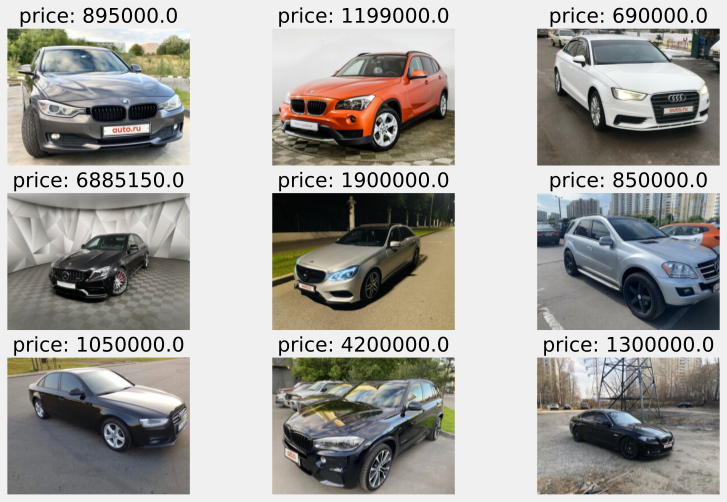

In [63]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    #print(path.__str__())
    im = PIL.Image.open(DATA_DIR+'img/img/' + path.__str__() + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + random_image_cat[index].__str__())
    plt.axis('off')
plt.show()

In [64]:
data

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,Владельцы,Владение,ПТС,Привод,Руль,sample,price,model_age,mile_per_year,name_xDrive
0,универсал,MERCEDES,чёрный,весь привет продать эксклюзивный проект универ...,3.0,220,бензин,350000,1984,W124,...,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый,0,0.0,37,9459,0
1,купе,BMW,белый,продавать любимый тачил обвес тюнинг потому ез...,3.0,310,дизель,15000,2011,6ER,...,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый,0,0.0,10,1500,1
2,купе,BMW,пурпурный,машина продаваться первый но только перебрать ...,2.5,220,бензин,166600,2005,3ER,...,3 или более,NaN,Оригинал,полный,Левый,0,0.0,16,10412,0
3,седан,BMW,белый,автомобиль отличный состояние весь родный крас...,2.0,140,бензин,147000,2005,3ER,...,2 владельца,NaN,Оригинал,задний,Левый,0,0.0,16,9187,0
4,седан,BMW,чёрный,немка бесключивый доступ камера задний вид авт...,2.0,190,дизель,24000,2016,5ER,...,1 владелец,NaN,Оригинал,полный,Левый,0,0.0,5,4800,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8348,седан,BMW,серый,купить официальный дилер г третий владелец вла...,2.0,150,бензин,232777,2005,3ER,...,3 или более,NaN,Оригинал,задний,Левый,1,550000.0,16,14548,0
8349,седан,BMW,чёрный,торг место всё работать сборка немецкий резина...,2.0,190,дизель,33700,2013,5ER,...,3 или более,2 года и 2 месяца,Оригинал,задний,Левый,1,1900000.0,8,4212,0
8350,седан,BMW,белый,автомобиль отличный состояние авто семья обслу...,2.0,140,бензин,200000,2008,3ER,...,3 или более,2 года и 2 месяца,Оригинал,задний,Левый,1,530000.0,13,15384,0
8351,седан,AUDI,чёрный,удлинённый заводский база вообще правильно зав...,3.0,310,бензин,72000,2013,A8,...,3 или более,NaN,Оригинал,полный,Левый,1,1970000.0,8,9000,0


In [65]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'][index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + sell_id.__str__() + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5678, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

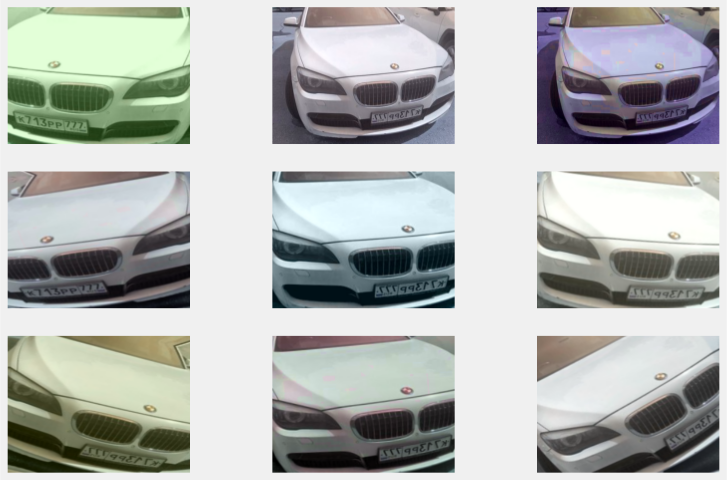

In [66]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

# Возьмем аугментации изображений, из предыдущего проекта Ford_Ferrari, с учтемом нужного размера изображений
augmentations = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4,
                          value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=224, width=200),
        albumentations.CenterCrop(height=200, width=224),
    ], p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.1, contrast_limit=0.1)
    ], p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(240, 320)
])

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentations(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    #print(img.shape)
plt.show()

In [67]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentations(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [68]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data_NLP['description'])


In [69]:
# Настройки без проброса признака
# def process_image(image):
#     return augmentations(image = image.numpy())['image']

# def tokenize_(descriptions):
#     return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)
#     # print(descriptions)
#     # return sequence.pad_sequences([tokenizer.encode(descriptions, add_special_tokens=True)], maxlen=MAX_SEQUENCE_LENGTH)
 

# def tokenize_text(text):
#     return tokenize_([text.numpy().decode('utf-8')])[0]

# def tf_process_train_dataset_element(image, table_data, text, price):
#     im_shape = image.shape
#     [image,] = tf.py_function(process_image, [image], [tf.uint8])
#     image.set_shape(im_shape)
#     [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
#     return (image, table_data, text), price

# def tf_process_val_dataset_element(image, table_data, text, price):
#     [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
#     return (image, table_data, text), price

# train_dataset = tf.data.Dataset.from_tensor_slices((
#     images_train, X_train, data.description[X_train.index], y_train
#     )).map(tf_process_train_dataset_element)

# test_dataset = tf.data.Dataset.from_tensor_slices((
#     images_test, X_test, data.description[X_test.index], y_test
#     )).map(tf_process_val_dataset_element)

# y_sub = np.zeros(len(X_sub))
# sub_dataset = tf.data.Dataset.from_tensor_slices((
#     images_sub, X_sub, data.description[X_sub.index], y_sub
#     )).map(tf_process_val_dataset_element)

# #проверяем, что нет ошибок (не будет выброшено исключение):
# train_dataset.__iter__().__next__();
# test_dataset.__iter__().__next__();
# sub_dataset.__iter__().__next__();

In [101]:
# Настройки с пробросом признака

def process_image(image):
    return augmentations(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)
    # print(descriptions)
    # return sequence.pad_sequences([tokenizer.encode(descriptions, add_special_tokens=True)], maxlen=MAX_SEQUENCE_LENGTH)
 

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, productionDate, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text, productionDate), price

def tf_process_val_dataset_element(image, table_data, text, productionDate, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text, productionDate), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description[X_train.index], data.productionDate[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description[X_test.index], data.productionDate[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description[X_sub.index], data.productionDate[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [102]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
# Попробуем разные модели:
# EfficientNetB4
# EfficientNetB3
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(
    weights = 'imagenet', 
    include_top = False, 
    input_shape = (size[1], size[0], 3))

# Для начала, сеть, которую подгрузили,никак не обучаем. 
# Будем обучать только верхние слои,которые мы рандомно инициализировали
efficientnet_model.trainable = True

# Будем работать со слоями начиная с этого момента
fine_tune_at = len(efficientnet_model.layers)//2

# Keep all other layers frozen
for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
# проверим количество и статус слоев
print(len(efficientnet_model.layers))

# for layer in efficientnet_model.layers:
#     print(layer, layer.trainable)

efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

384


In [103]:
# MLP строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.InputLayer(X.shape[1]),
    # L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'sigmoid'),  # изменим функцию активации
    L.LayerNormalization(),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),#добавили еще один полносвязный слой 
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [109]:
# NLP: немного изменим базовую архитектуру
nlp_model = Sequential([
    L.InputLayer(MAX_SEQUENCE_LENGTH, name="seq_description"),
    # L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LayerNormalization(), #добавили нормализацию
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.Dense(128, activation = 'sigmoid'), #добавили полносвязный слой с функцией активации sigmoid
    L.Dropout(0.5),
    L.LSTM(64),
    L.Dropout(0.25),
    L.Dense(64),
    L.Dropout(0.25)
    ])
# nlp_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 256, 256)          3670016   
_________________________________________________________________
layer_normalization_4 (Layer (None, 256, 256)          512       
_________________________________________________________________
lstm_4 (LSTM)                (None, 256, 256)          525312    
_________________________________________________________________
dropout_12 (Dropout)         (None, 256, 256)          0         
_________________________________________________________________
dense_18 (Dense)             (None, 256, 128)          32896     
_________________________________________________________________
dropout_13 (Dropout)         (None, 256, 128)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)               

In [132]:
# FEATURE Input
# Iput
productiondate = L.Input(shape=[1], name="productiondate")
# Embeddings layers
emb_productiondate = L.Embedding(len(X.productionDate.unique().tolist())+1, 20)(productiondate)
f_productiondate =  L.Flatten()(emb_productiondate)

# f_productiondate = Sequential([
#     L.Input(shape=[1], name="productiondate"),
#     L.Embedding(len(X.productionDate.unique().tolist())+1, 20, name="emb_productiondate")(productiondate),
#     L.Flatten()(emb_productiondate)
#     ])
f_productiondate

# model_nlp = Sequential()
# model_nlp.add(L.InputLayer(MAX_SEQUENCE_LENGTH, name="seq_description"))
# # model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
# model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
# model_nlp.add(L.LSTM(256, return_sequences=True))
# model_nlp.add(L.Dropout(0.5))
# model_nlp.add(L.LSTM(128,))
# model_nlp.add(L.Dropout(0.25))
# model_nlp.add(L.Dense(64, activation="relu"))
# model_nlp.add(L.Dropout(0.25))

<KerasTensor: shape=(None, 200) dtype=float32 (created by layer 'flatten_14')>

In [136]:
# объединяем выходы трех нейросетей
combinedInput = L.concatenate(
    [efficientnet_output, 
     tabular_model.output, 
     nlp_model.output, 
     f_productiondate])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input,
                      tabular_model.input, 
                      nlp_model.input,
                      f_productiondate], outputs=head)
model.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: flatten_14/Reshape:0


ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 10), dtype=tf.float32, name='productiondate'), name='productiondate', description="created by layer 'productiondate'") at layer "embedding_16". The following previous layers were accessed without issue: ['rescaling_2', 'normalization_2', 'stem_conv_pad', 'stem_conv', 'stem_bn', 'stem_activation', 'block1a_dwconv', 'block1a_bn', 'block1a_activation', 'block1a_se_squeeze', 'block1a_se_reshape', 'block1a_se_reduce', 'block1a_se_expand', 'block1a_se_excite', 'block1a_project_conv', 'block1a_project_bn', 'block1b_dwconv', 'block1b_bn', 'block1b_activation', 'block1b_se_squeeze', 'block1b_se_reshape', 'block1b_se_reduce', 'block1b_se_expand', 'block1b_se_excite', 'block1b_project_conv', 'block1b_project_bn', 'block1b_drop', 'block1b_add', 'block2a_expand_conv', 'block2a_expand_bn', 'block2a_expand_activation', 'block2a_dwconv_pad', 'block2a_dwconv', 'block2a_bn', 'block2a_activation', 'block2a_se_squeeze', 'block2a_se_reshape', 'block2a_se_reduce', 'block2a_se_expand', 'block2a_se_excite', 'block2a_project_conv', 'block2a_project_bn', 'block2b_expand_conv', 'block2b_expand_bn', 'block2b_expand_activation', 'block2b_dwconv', 'block2b_bn', 'block2b_activation', 'block2b_se_squeeze', 'block2b_se_reshape', 'block2b_se_reduce', 'block2b_se_expand', 'block2b_se_excite', 'block2b_project_conv', 'block2b_project_bn', 'block2b_drop', 'block2b_add', 'block2c_expand_conv', 'block2c_expand_bn', 'block2c_expand_activation', 'block2c_dwconv', 'block2c_bn', 'block2c_activation', 'block2c_se_squeeze', 'block2c_se_reshape', 'block2c_se_reduce', 'block2c_se_expand', 'block2c_se_excite', 'block2c_project_conv', 'block2c_project_bn', 'block2c_drop', 'block2c_add', 'block3a_expand_conv', 'block3a_expand_bn', 'block3a_expand_activation', 'block3a_dwconv_pad', 'block3a_dwconv', 'block3a_bn', 'block3a_activation', 'block3a_se_squeeze', 'block3a_se_reshape', 'block3a_se_reduce', 'block3a_se_expand', 'block3a_se_excite', 'block3a_project_conv', 'block3a_project_bn', 'block3b_expand_conv', 'block3b_expand_bn', 'block3b_expand_activation', 'block3b_dwconv', 'block3b_bn', 'block3b_activation', 'block3b_se_squeeze', 'block3b_se_reshape', 'block3b_se_reduce', 'block3b_se_expand', 'block3b_se_excite', 'block3b_project_conv', 'block3b_project_bn', 'block3b_drop', 'block3b_add', 'block3c_expand_conv', 'block3c_expand_bn', 'block3c_expand_activation', 'block3c_dwconv', 'block3c_bn', 'block3c_activation', 'block3c_se_squeeze', 'block3c_se_reshape', 'block3c_se_reduce', 'block3c_se_expand', 'block3c_se_excite', 'block3c_project_conv', 'block3c_project_bn', 'block3c_drop', 'block3c_add', 'block4a_expand_conv', 'block4a_expand_bn', 'block4a_expand_activation', 'block4a_dwconv_pad', 'block4a_dwconv', 'block4a_bn', 'block4a_activation', 'block4a_se_squeeze', 'block4a_se_reshape', 'block4a_se_reduce', 'block4a_se_expand', 'block4a_se_excite', 'block4a_project_conv', 'block4a_project_bn', 'block4b_expand_conv', 'block4b_expand_bn', 'block4b_expand_activation', 'block4b_dwconv', 'block4b_bn', 'block4b_activation', 'block4b_se_squeeze', 'block4b_se_reshape', 'block4b_se_reduce', 'block4b_se_expand', 'block4b_se_excite', 'block4b_project_conv', 'block4b_project_bn', 'block4b_drop', 'block4b_add', 'block4c_expand_conv', 'block4c_expand_bn', 'block4c_expand_activation', 'block4c_dwconv', 'block4c_bn', 'block4c_activation', 'block4c_se_squeeze', 'block4c_se_reshape', 'block4c_se_reduce', 'block4c_se_expand', 'block4c_se_excite', 'block4c_project_conv', 'block4c_project_bn', 'block4c_drop', 'block4c_add', 'block4d_expand_conv', 'block4d_expand_bn', 'block4d_expand_activation', 'block4d_dwconv', 'block4d_bn', 'block4d_activation', 'block4d_se_squeeze', 'block4d_se_reshape', 'block4d_se_reduce', 'block4d_se_expand', 'block4d_se_excite', 'block4d_project_conv', 'block4d_project_bn', 'block4d_drop', 'block4d_add', 'block4e_expand_conv', 'block4e_expand_bn', 'block4e_expand_activation', 'block4e_dwconv', 'block4e_bn', 'block4e_activation', 'block4e_se_squeeze', 'block4e_se_reshape', 'block4e_se_reduce', 'block4e_se_expand', 'block4e_se_excite', 'block4e_project_conv', 'block4e_project_bn', 'block4e_drop', 'block4e_add', 'block5a_expand_conv', 'block5a_expand_bn', 'block5a_expand_activation', 'block5a_dwconv', 'block5a_bn', 'block5a_activation', 'block5a_se_squeeze', 'block5a_se_reshape', 'block5a_se_reduce', 'block5a_se_expand', 'block5a_se_excite', 'block5a_project_conv', 'block5a_project_bn', 'block5b_expand_conv', 'block5b_expand_bn', 'block5b_expand_activation', 'block5b_dwconv', 'block5b_bn', 'block5b_activation', 'block5b_se_squeeze', 'block5b_se_reshape', 'block5b_se_reduce', 'block5b_se_expand', 'block5b_se_excite', 'block5b_project_conv', 'block5b_project_bn', 'block5b_drop', 'block5b_add', 'block5c_expand_conv', 'block5c_expand_bn', 'block5c_expand_activation', 'block5c_dwconv', 'block5c_bn', 'block5c_activation', 'block5c_se_squeeze', 'block5c_se_reshape', 'block5c_se_reduce', 'block5c_se_expand', 'block5c_se_excite', 'block5c_project_conv', 'block5c_project_bn', 'block5c_drop', 'block5c_add', 'block5d_expand_conv', 'block5d_expand_bn', 'block5d_expand_activation', 'block5d_dwconv', 'block5d_bn', 'block5d_activation', 'block5d_se_squeeze', 'block5d_se_reshape', 'block5d_se_reduce', 'block5d_se_expand', 'block5d_se_excite', 'block5d_project_conv', 'block5d_project_bn', 'block5d_drop', 'block5d_add', 'block5e_expand_conv', 'block5e_expand_bn', 'block5e_expand_activation', 'block5e_dwconv', 'block5e_bn', 'block5e_activation', 'block5e_se_squeeze', 'block5e_se_reshape', 'block5e_se_reduce', 'block5e_se_expand', 'block5e_se_excite', 'block5e_project_conv', 'block5e_project_bn', 'block5e_drop', 'block5e_add', 'block6a_expand_conv', 'block6a_expand_bn', 'block6a_expand_activation', 'block6a_dwconv_pad', 'block6a_dwconv', 'block6a_bn', 'block6a_activation', 'block6a_se_squeeze', 'block6a_se_reshape', 'block6a_se_reduce', 'block6a_se_expand', 'block6a_se_excite', 'block6a_project_conv', 'block6a_project_bn', 'block6b_expand_conv', 'block6b_expand_bn', 'block6b_expand_activation', 'block6b_dwconv', 'block6b_bn', 'block6b_activation', 'block6b_se_squeeze', 'block6b_se_reshape', 'block6b_se_reduce', 'block6b_se_expand', 'block6b_se_excite', 'block6b_project_conv', 'block6b_project_bn', 'block6b_drop', 'block6b_add', 'block6c_expand_conv', 'block6c_expand_bn', 'block6c_expand_activation', 'block6c_dwconv', 'block6c_bn', 'block6c_activation', 'block6c_se_squeeze', 'block6c_se_reshape', 'block6c_se_reduce', 'block6c_se_expand', 'block6c_se_excite', 'block6c_project_conv', 'block6c_project_bn', 'block6c_drop', 'block6c_add', 'block6d_expand_conv', 'block6d_expand_bn', 'block6d_expand_activation', 'block6d_dwconv', 'block6d_bn', 'block6d_activation', 'block6d_se_squeeze', 'block6d_se_reshape', 'block6d_se_reduce', 'block6d_se_expand', 'block6d_se_excite', 'block6d_project_conv', 'block6d_project_bn', 'block6d_drop', 'block6d_add', 'block6e_expand_conv', 'block6e_expand_bn', 'block6e_expand_activation', 'block6e_dwconv', 'block6e_bn', 'block6e_activation', 'block6e_se_squeeze', 'block6e_se_reshape', 'block6e_se_reduce', 'block6e_se_expand', 'block6e_se_excite', 'block6e_project_conv', 'block6e_project_bn', 'block6e_drop', 'block6e_add', 'block6f_expand_conv', 'block6f_expand_bn', 'block6f_expand_activation', 'block6f_dwconv', 'block6f_bn', 'block6f_activation', 'block6f_se_squeeze', 'block6f_se_reshape', 'block6f_se_reduce', 'block6f_se_expand', 'block6f_se_excite', 'block6f_project_conv', 'block6f_project_bn', 'block6f_drop', 'block6f_add', 'block7a_expand_conv', 'block7a_expand_bn', 'block7a_expand_activation', 'block7a_dwconv', 'block7a_bn', 'block7a_activation', 'block7a_se_squeeze', 'block7a_se_reshape', 'block7a_se_reduce', 'block7a_se_expand', 'block7a_se_excite', 'block7a_project_conv', 'block7a_project_bn', 'block7b_expand_conv', 'block7b_expand_bn', 'block7b_expand_activation', 'block7b_dwconv', 'block7b_bn', 'block7b_activation', 'block7b_se_squeeze', 'block7b_se_reshape', 'block7b_se_reduce', 'embedding_5', 'block7b_se_expand', 'layer_normalization_4', 'block7b_se_excite', 'lstm_4', 'block7b_project_conv', 'dropout_12', 'block7b_project_bn', 'dense_18', 'dense_11', 'block7b_drop', 'dropout_13', 'layer_normalization_2', 'block7b_add', 'lstm_5', 'dropout_6', 'top_conv', 'dropout_14', 'dense_12', 'top_bn']

In [121]:
# попробуем применить ExponentialDecay для управления learning rate
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100, decay_rate=0.9)

# optimizer = tf.keras.optimizers.Adam(0.005)
# model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
#               loss='MAPE',
#               metrics=['MAPE'])

# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

In [117]:
checkpoint = ModelCheckpoint(
    'working/best_model.hdf5', monitor='val_MAPE', save_best_only=True, verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [122]:
history = model.fit(train_dataset.batch(15),
                    epochs=100,
                    validation_data = test_dataset.batch(15),
                    callbacks=callbacks_list
                   )

Epoch 1/100


InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument:  indices[0,0] = 2011 is not in [0, 39)
	 [[node model_5/embedding_10/embedding_lookup (defined at \AppData\Local\Temp/ipykernel_11476/2526692876.py:1) ]]
  (1) Invalid argument:  indices[0,0] = 2011 is not in [0, 39)
	 [[node model_5/embedding_10/embedding_lookup (defined at \AppData\Local\Temp/ipykernel_11476/2526692876.py:1) ]]
	 [[model_5/embedding_10/embedding_lookup/_30]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_1469633]

Errors may have originated from an input operation.
Input Source operations connected to node model_5/embedding_10/embedding_lookup:
 model_5/embedding_10/embedding_lookup/1463902 (defined at \anaconda3\envs\tensorflow_25\lib\contextlib.py:113)

Input Source operations connected to node model_5/embedding_10/embedding_lookup:
 model_5/embedding_10/embedding_lookup/1463902 (defined at \anaconda3\envs\tensorflow_25\lib\contextlib.py:113)

Function call stack:
train_function -> train_function


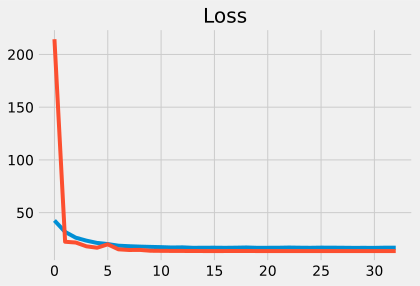

In [77]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [78]:
model.load_weights('working/best_model.hdf5')
model.save('working/nn_final.hdf5')

In [79]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")
# log TEST mape: 1.21%
# TEST mape: 11.95%

TEST mape: 13.57%


In [80]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
#sub_predict_nn3 = (np.exp(model.predict(sub_dataset.batch(30)))-1).astype("int")
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

# 82
# Sergey Pinaev
# 11.93957


In [ ]:
# model.load_weights('working/best_model.hdf5')
# test_predict_nn_bonus = model.predict([X_test, X_test.productionDate.values])
# print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

# blend_predict = (test_predict_catboost + test_predict_nn_bonus[:,0]) / 2
# print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

# Применим Fine-tuning и обучим оставшиеся слои

In [81]:

#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
# Попробуем разные модели:
# EfficientNetB3
# EfficientNetB4
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB4(
    weights = 'imagenet', 
    include_top = False, 
    input_shape = (size[1], size[0], 3))

# Для начала, сеть, которую подгрузили,никак не обучаем. 
# Будем обучать только верхние слои,которые мы рандомно инициализировали
efficientnet_model.trainable = True

# проверим количество и статус слоев
print(len(efficientnet_model.layers))

# for layer in efficientnet_model.layers:
#     print(layer, layer.trainable)

efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

474


In [83]:
# объединяем выходы трех нейросетей
combinedInput = L.concatenate(
    [efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input,
                      tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 240, 320, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 240, 320, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

In [84]:
# попробуем применить ExponentialDecay для управления learning rate
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100, decay_rate=0.9)

# optimizer = tf.keras.optimizers.Adam(0.005)
# model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
#               loss='MAPE',
#               metrics=['MAPE'])

# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

In [85]:
# Загружаем предобученные веса
model.load_weights('working/best_model.hdf5')

In [86]:
checkpoint = ModelCheckpoint(
    'working/best_model_1.hdf5', monitor='val_MAPE', save_best_only=True, verbose=0, mode='min')
earlystop = EarlyStopping(
    monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [88]:
history = model.fit(train_dataset.batch(10),
                    epochs=100,
                    validation_data = test_dataset.batch(10),
                    callbacks=callbacks_list
                   )

Epoch 1/100
568/568 [==============================] - 229s 399ms/step - loss: 27.6416 - MAPE: 27.6416 - val_loss: 22.3291 - val_MAPE: 22.3291
Epoch 2/100
568/568 [==============================] - 225s 397ms/step - loss: 24.9815 - MAPE: 24.9815 - val_loss: 22.1249 - val_MAPE: 22.1249
Epoch 3/100
568/568 [==============================] - 225s 396ms/step - loss: 21.8455 - MAPE: 21.8455 - val_loss: 16.7413 - val_MAPE: 16.7413
Epoch 4/100
568/568 [==============================] - 225s 395ms/step - loss: 20.1544 - MAPE: 20.1544 - val_loss: 17.6367 - val_MAPE: 17.6367
Epoch 5/100
568/568 [==============================] - 222s 390ms/step - loss: 18.6689 - MAPE: 18.6689 - val_loss: 16.2343 - val_MAPE: 16.2343
Epoch 6/100
568/568 [==============================] - 223s 392ms/step - loss: 17.9098 - MAPE: 17.9098 - val_loss: 16.9347 - val_MAPE: 16.9347
Epoch 7/100
568/568 [==============================] - 222s 390ms/step - loss: 17.4417 - MAPE: 17.4417 - val_loss: 17.2674 - val_MAPE: 17.2674

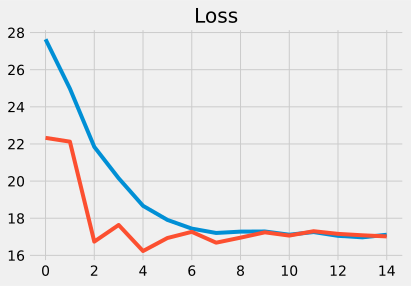

In [89]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [90]:
model.save('working/nn_final_1.hdf5')

In [91]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")
# log TEST mape: 1.21%
# TEST mape: 11.95%

TEST mape: 16.23%


In [92]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
#sub_predict_nn3 = (np.exp(model.predict(sub_dataset.batch(30)))-1).astype("int")
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_1_submission.csv', index=False)

# Blend

In [150]:
sample_submission1 = pd.read_csv('catboost_submission.csv').price
sample_submission2 = pd.read_csv('nn3_submission.csv').price
blend_predict = (sample_submission1 + sample_submission2) / 2
blend_predict

0        544827.28
1       2307136.10
2        624628.78
3        536230.53
4       2516452.50
           ...    
1666    1066418.75
1667    2381148.40
1668    1391138.00
1669    1078478.15
1670    1026324.85
Name: price, Length: 1671, dtype: float64

In [145]:
#print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: inf%


In [151]:
#blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_predict
sample_submission.to_csv('blend_submission.csv', index=False)

# Conclusion

## Что делал:
* Попробовал разные архитектуры сетеи и модели EfficientNetB3 и EfficientNetB4
* Провел как мог, детальный анализ результатов
* Применил ExponentialDecay для управления learning rate
* Попробовл SGD оптимизатор
* Поработать с таргетом
* Использовать Fine-tuning
* От двух признаков взял логарифм перед нормализацией, чтобы подать данные с распределением близким к нормальному
* Распарсил и извлек числовые значение из признаков: 'engineDisplacement', 'enginePower', 'Владение'
* Удалил некоторые признаки для сокращения размерности
* Выделил наличие xDrive в качестве отдельного признака.
* Поработал над Feature engineering

#### NLP
* Провел лемантизацию текста и удалил стоп слова
* Попробовал подключить сеть Bearer которая извлечет векторное пространство слов. Векторы получить получилось, но корректно завести это в tf.data.Dataset не получилось, поэтому оставил стандартный токенезатор

#### CV
* Попробовал различные аугментации
* Применил Fine-tuning, обучив сначала 50% весов, затем 100%
* Попытался пробросить признак, но видимо из-за того что испольщуется  tf.data.Dataset сеть падала в ошибку, поэтому не получилось.
* Попробовал блендин, но улучшить результат не удалось

## Результат
**Только 82 место на Kaggle Sergey Pinaev 11.93957**

**P.S**  *Я считаю, что это одно из самых крутых заданий на курсе и оно требует очень много времени для того чтобы попробовать все то, о чем рассказано в модуле. Но! из-за того, что на прошлый модуль ЮНИТ 8. было выделено 1.5 месяца, то на этот всего 1 месяц я много чего не успел попробовать. Хотя этот модуль на порядк сложнее и после каждой темы есть еще домашнее задание за которое я даже не брался! Думаю на этот модуль нужно гдето 2 месяца.*